In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd



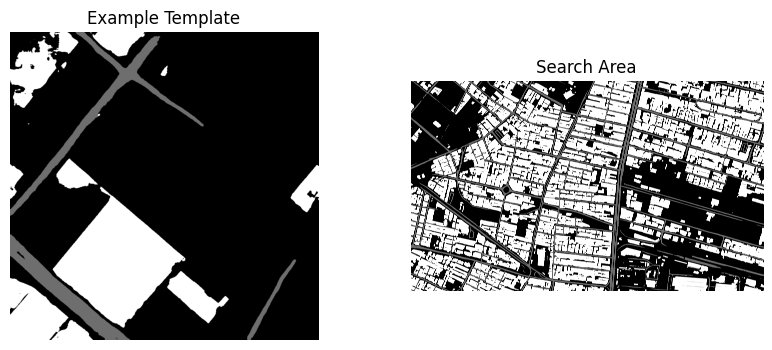

In [ ]:
example_dir = Path("matching/tests/1")
search_image = cv2.imread(str(example_dir / "search_area_mask.png"), 0)
region_path = sorted((example_dir / "regoins_segments").glob("*.png"))[0]
template = cv2.imread(str(region_path), 0)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(template, cmap='gray')
plt.title("Example Template")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(search_image, cmap='gray')
plt.title("Search Area")
plt.axis('off')
plt.show()

In [58]:
def match_template_with_homography(template, search_img):
    orb = cv2.ORB_create(1000)
    kp1, des1 = orb.detectAndCompute(template, None)
    kp2, des2 = orb.detectAndCompute(search_img, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) >= 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return kp1, kp2, matches, H
    else:
        return kp1, kp2, matches, None

In [59]:
def load_images(batch_dir):
    search_image = cv2.imread(str(batch_dir / "search_area_mask.png"), 0)
    region_dir = batch_dir / "regoins_segments"
    region_images = sorted(region_dir.glob("*.png"))
    return search_image, region_images


In [60]:
def evaluate_batches(base_path):
    results = []
    for batch_dir in Path(base_path).glob("*"):
        if not batch_dir.is_dir():
            continue

        search_img, region_paths = load_images(batch_dir)
        for template_path in region_paths:
            template = cv2.imread(str(template_path), 0)
            kp1, kp2, matches, H = match_template_with_homography(template, search_img)

            if H is not None:
                results.append({
                    "batch": batch_dir.name,
                    "template": template_path.name,
                    "valid": True,
                    "match_count": len(matches)
                })
            else:
                results.append({
                    "batch": batch_dir.name,
                    "template": template_path.name,
                    "valid": False,
                    "match_count": len(matches)
                })
    return pd.DataFrame(results)

  batch template  valid  match_count
0     1    0.png   True          149
1     1    1.png   True          219
2     1   10.png   True          220
3     1   11.png   True          226
4     1   12.png   True          203


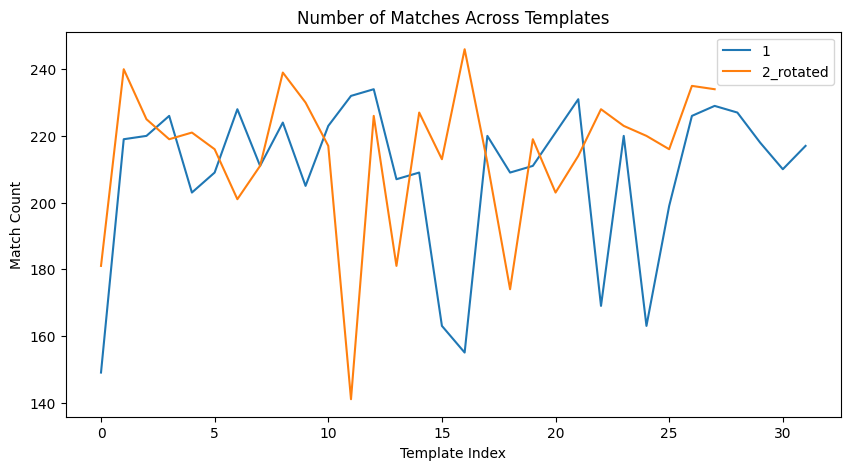

In [61]:
df = evaluate_batches("matching/tests")
print(df.head())

plt.figure(figsize=(10, 5))
for batch in df['batch'].unique():
    subset = df[df['batch'] == batch]
    plt.plot(subset['match_count'].values, label=batch)
plt.title("Number of Matches Across Templates")
plt.xlabel("Template Index")
plt.ylabel("Match Count")
plt.legend()
plt.show()


In [ ]:
def load_ground_truth(batch_dir):
    # Load the CSV file with ground truth data, adapt based on CSV structure
    gt_path = batch_dir / "result.csv"
    return pd.read_csv(gt_path)

In [62]:
def compute_center_error(pred_corners, gt_x, gt_y):
    pred_center = np.mean(pred_corners.reshape(-1, 2), axis=0)
    gt_center = np.array([gt_x, gt_y])
    error = np.linalg.norm(pred_center - gt_center)
    return error


In [63]:
def evaluate_batches_with_error(base_path, error_threshold=10):
    results = []
    for batch_dir in Path(base_path).glob("*"):
        if not batch_dir.is_dir():
            continue
        
        search_img, region_paths = load_images(batch_dir)
        gt_df = pd.read_csv(batch_dir / "result.csv")
        
        for template_path in region_paths:
            template = cv2.imread(str(template_path), 0)
            kp1, kp2, matches, H = match_template_with_homography(template, search_img)
            template_name = template_path.name
            
            gt_row = gt_df[gt_df['template'] == template_name] if 'template' in gt_df.columns else gt_df
            # if no template column, just assume one row per template in order
            if gt_row.empty:
                continue
            
            gt_x = gt_row.iloc[0]['Main X']
            gt_y = gt_row.iloc[0]['Main Y']
            
            if H is not None:
                h, w = template.shape
                pred_corners = cv2.perspectiveTransform(
                    np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2), H)
                error = compute_center_error(pred_corners, gt_x, gt_y)
                valid = error < error_threshold
                results.append({
                    "batch": batch_dir.name,
                    "template": template_name,
                    "valid": valid,
                    "error": error,
                    "match_count": len(matches)
                })
            else:
                results.append({
                    "batch": batch_dir.name,
                    "template": template_name,
                    "valid": False,
                    "error": None,
                    "match_count": len(matches)
                })
    return pd.DataFrame(results)

  batch template  valid        error  match_count
0     1    0.png  False  3667.754708          149
1     1    1.png  False  6625.129493          219
2     1   10.png  False  4101.092713          220
3     1   11.png  False  8137.651870          226
4     1   12.png  False  4354.672987          203


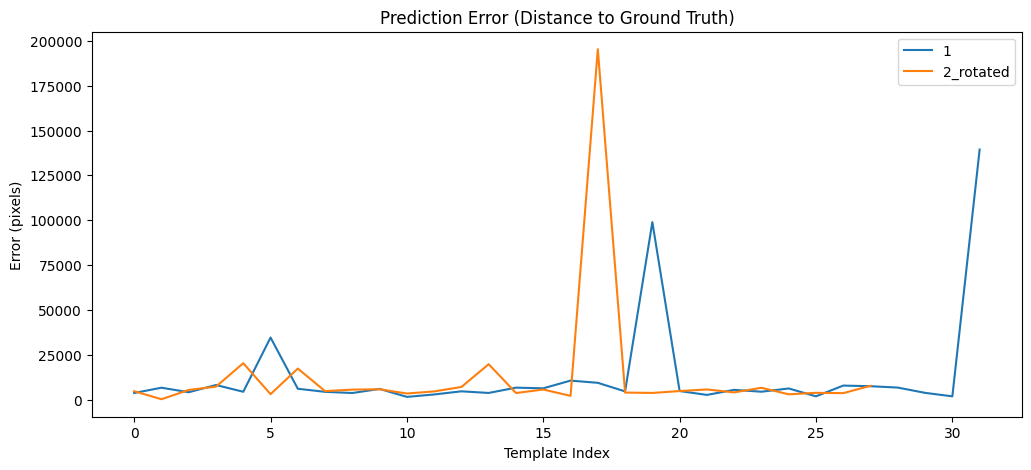

In [64]:
df_results = evaluate_batches_with_error("matching/tests", error_threshold=10)
print(df_results.head())


plt.figure(figsize=(12, 5))
for batch in df_results['batch'].unique():
    subset = df_results[df_results['batch'] == batch]
    plt.plot(subset['error'].fillna(0).values, label=batch)
plt.title("Prediction Error (Distance to Ground Truth)")
plt.xlabel("Template Index")
plt.ylabel("Error (pixels)")
plt.legend()
plt.show()



In [ ]:
# Plot accuracy per batch
accuracy_by_batch = df_results.groupby('batch')['valid'].mean()
accuracy_by_batch.plot(kind='bar', title='Matching Accuracy by Batch')
plt.ylabel('Accuracy')
plt.show()